In [59]:
import serial
import serial.tools.list_ports
import time
import json
import io
import struct
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
with np.load('../train/mnist.npz') as f:
    x_train, y_train = f['x_train'], f['y_train']

x_train = x_train/255
y_train = keras.utils.to_categorical(y_train)

print('This is how a one-hot encoded 5 looks like')
print(y_train[0])

This is how a one-hot encoded 5 looks like
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [61]:
ports = serial.tools.list_ports.comports()

for __port in ports:
    print(__port.name)


port = serial.Serial("/dev/cu.usbmodem101", baudrate=115200, timeout=1)

cu.wlan-debug
cu.Bluetooth-Incoming-Port
cu.usbmodem101


## Test send command

In [118]:
command = {"command":0, "ds":100}
command_json = json.dumps(command)
print(command_json)

command_json += "\n"
port.write(command_json.encode())
time.sleep(0.1)

print(port.read_all())

{"command": 0, "ds": 100}
b'{"payload":"[1] Received {\\"command\\": 0, \\"ds\\": 100}\\n\\n","type":0}\r\n{"payload":"[2] Received command with type: 0\\n","type":0}\r\n{"payload":"[2] New state: 3\\n","type":0}\r\n'


In [167]:
port.read_all()

b'{"payload":"[2] Test environment.\\n","type":0}\r\n{"payload":"[2] Thomas Widmann.\\n","type":0}\r\n{"payload":"[2] Start state machine. Current state: 0\\n","type":0}\r\n{"payload":"[2] New state: 0\\n","type":0}\r\n{"payload":"[2] New state: 1\\n","type":0}\r\n{"payload":"[1] Input type: 1\\n","type":0}\r\n{"payload":"[1] Input dims size: 4\\n","type":0}\r\n{"payload":"[1] Output type: 1\\n","type":0}\r\n{"payload":"[1] Output dims size: 2\\n","type":0}\r\n{"payload":"[2] New state: 2\\n","type":0}\r\n'

In [168]:
command = {"command":0, "ds":3136, "repeat": 30}
command_json = json.dumps(command)
print(command_json)

command_json += "\n"
port.write(command_json.encode())
time.sleep(0.1)

print(port.read_all())

{"command": 0, "ds": 3136, "repeat": 30}
b'{"payload":"[1] Received {\\"command\\": 0, \\"ds\\": 3136, \\"repeat\\": 30}\\n\\n","type":0}\r\n{"payload":"[2] Received command with type: 0\\n","type":0}\r\n{"payload":"[2] New state: 3\\n","type":0}\r\n'


In [165]:
port.close()
port.open()

In [8]:
def convert_float_list_to_bytes(data):
    data_bytes = []
    for dat in data:
        bytes_ = list(struct.pack("!f", dat))
        bytes_.reverse()
        data_bytes.extend(bytes_)

    return data_bytes

In [169]:
k = 2
image = np.float32(x_train[k])
image = image.reshape(28*28,)
image_bytes = convert_float_list_to_bytes(image)
port.write(image_bytes)

time.sleep(3)

timing_samples = []

while(True):
    lineData = port.readline()
    line = str(lineData)

    if len(lineData) == 0:
        break

    lineJsonData = io.BytesIO(lineData)
    lineJson = json.load(lineJsonData)

    if lineJson["type"] == 1:
        data = lineJson["payload"]["data"]
        for sample in data:
            timing_samples.append(sample["time_us"])
            #print(sample["time_us"])

        
        #print(lineJson)

timing_samples = np.array(timing_samples)

pd.DataFrame(timing_samples).describe()

,0
count,30.000000
mean,109815.633333
std,61.656716
min,109758.000000
25%,109774.500000
50%,109798.000000
75%,109836.500000
max,110070.000000


<AxesSubplot:>

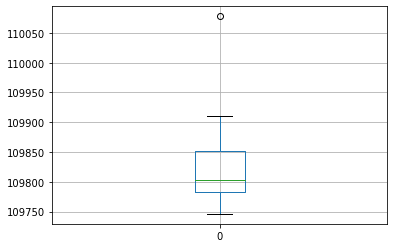

In [156]:
t_without_p = pd.DataFrame(timing_samples)
t_without_p.boxplot()

In [157]:
t_without_p.describe()

,0
count,30.000000
mean,109822.800000
std,63.968958
min,109746.000000
25%,109782.250000
50%,109803.500000
75%,109851.250000
max,110078.000000


<AxesSubplot:>

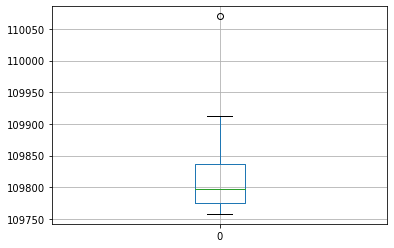

In [170]:
t_with_p = pd.DataFrame(timing_samples)
t_with_p.boxplot()

In [171]:
t_with_p.describe()

,0
count,30.000000
mean,109815.633333
std,61.656716
min,109758.000000
25%,109774.500000
50%,109798.000000
75%,109836.500000
max,110070.000000


## Test image send

In [9]:
def predict_on_pi(image):
    image_bytes = convert_float_list_to_bytes(image)
    port.write(image_bytes)
    reportData = port.readall()
    reportDataIO = io.BytesIO(reportData)
    reportJson = json.load(reportDataIO)
    return reportJson

In [29]:
k = 0
image = np.float32(x_train[k])
image = image.reshape(28*28,)
predict_on_pi(image)
print("Shape:", np.shape(image))
print("Type:", image.dtype)
print("Ground trouth:", y_train[k])


Shape: (784,)
Type: float32
Ground trouth: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Size: 3136 Bytes


## Measure timing

In [53]:
port.close()
port.open()

In [54]:
timing_samples = []
k = 0
image = np.float32(x_train[k])
image = image.reshape(28*28,)

cycles = 30
for cycle in range(cycles):
    report = predict_on_pi(image)
    timing_samples.append(report["timing"])
    print(cycle + 1, "/", cycles)

timing_samples = np.array(timing_samples)

1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30


In [55]:
pd.DataFrame(timing_samples).describe()

,0
count,30.00000
mean,109985.10000
std,36.58938
min,109919.00000
25%,109964.00000
50%,109978.00000
75%,110006.00000
max,110072.00000


In [46]:
pd.DataFrame(timing_samples).describe()

,0
count,10.000000
mean,109956.400000
std,35.239498
min,109910.000000
25%,109939.000000
50%,109944.000000
75%,109978.500000
max,110027.000000
